Carga de paquetes (y en el colab meter la imagen, habrá que quitar lo del google colab)

In [126]:
import pywt
import pywt.data
from PIL import Image
import numpy as np
import cv2 # Para leer imagenes y meterles bordes, contornos y cosas
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

from google.colab import files

#uploaded = files.upload()


Cambiar el find contours por el connectedcomponents (va algo mejor):


Primero creamos la carpeta fotos donde se guardarán las letras segmentadas:

In [127]:
folder_path = '/fotos'
folder_name = "fotos"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"La carpeta {folder_path} ha sido eliminada.")

else:
    print(f"La carpeta {folder_path} no existe.")

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

La carpeta /fotos ha sido eliminada.


Ahora cargamos nuestra imagen y la transformamos a escala de grises:

In [128]:
image_path_in_colab="/content/WhatsApp Image 2023-11-17 at 12.19.16.jpeg"

image = cv2.imread(image_path_in_colab)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Ahora, aplicamos el algoritmo de canny para detectar los bordes de la imagen, pasando a negro todo lo demás:

In [129]:
edged_image = cv2.Canny(gray, threshold1=30, threshold2=100)

Ahora procedemos a segmentar la imagen detectando las letras como componentes conectados (agrupaciones conectadas entre sí). Gracias a realzar tanto los bordes, esta clasificación es posible, ya que son los que permite que el algoritmo detecte las componentes conectadas.

In [130]:
regiones_recortadas = []
areas=[]
_, labels, stats, centroids = cv2.connectedComponentsWithStats(edged_image)

for i, stat in enumerate(stats):
    area = stat[cv2.CC_STAT_AREA]

    if area > 100 and area < 700:
        areas.append(area)

        x, y, w, h = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT]

        roi = edged_image[y:y+h, x:x+w]
        centroide = centroids[i]
        regiones_recortadas.append((roi, centroide))

Debido a tener una imagen sin relleno, en letras como la O donde no todos los bordes están conectados entre sí detecta más de una letra. Para solucionarlo, vamos a ordenar estas componentes por area, y después vamos a eliminar una letra si está muy cerca de otra (centroides cercanos) y su area es más pequeña (para quedarnos con la letra más grande, que suele ser la original).

In [131]:
indices = list(range(1, len(areas)))

indices_ordenados = sorted(indices, key=lambda i: areas[i - 1], reverse=True)

regiones_recortadas = [regiones_recortadas[i] for i in indices_ordenados]

distancia_minima = 40

regiones_finales = []
centroides_procesados = []

for region, centroide in regiones_recortadas:
    duplicada = False
    for centroide_procesado in centroides_procesados:
        distancia = np.sqrt(((centroide[0] - centroide_procesado[0]) ** 2) + ((centroide[1] - centroide_procesado[1]) ** 2))
        if distancia < distancia_minima:
            duplicada = True
            break

    if not duplicada:
        regiones_finales.append((region, centroide))
        centroides_procesados.append(centroide)

regiones_finales = sorted(regiones_finales, key=lambda x: (x[1][0], x[1][1]))

Ahora, para que nuestra red funcione correctamente, necesitamos que la letra no este hueca. Para solucionarlo, vamos a engrosar los bordes para rellenar la letra:

In [132]:
regiones_rellenadas = []
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

for region, centroide in regiones_finales:
    dilated_region = cv2.dilate(region, kernel, iterations=3)
    regiones_rellenadas.append((dilated_region, centroide))

Ahora vamos a reescalar las regiones a 28x28 píxeles y añadiendo bordes negros para que la red funcione correctamente:

In [133]:
regiones_redimensionadas = []
for region in regiones_rellenadas:
    h, w = region[0].shape[:2]
    max_dim = max(h, w)
    scale = 28.0 / max_dim
    new_h, new_w = int(h * scale), int(w * scale)
    resized_region = cv2.resize(region[0], (new_w, new_h))

    padded_region = np.zeros((28, 28), dtype=np.uint8)
    pad_h = (28 - new_h) // 2
    pad_w = (28 - new_w) // 2
    padded_region[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_region

    padded_region=cv2.copyMakeBorder(padded_region, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    regiones_redimensionadas.append(padded_region)

Por último, mostramos y guardamos las letras encontradas:

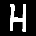

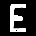

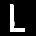

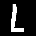

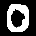

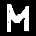

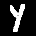

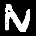

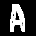

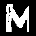

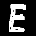

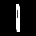

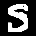

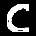

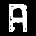

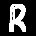

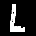

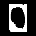

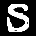

In [134]:
for i, region in enumerate(regiones_redimensionadas):
    cv2.imwrite(os.path.join(folder_path, f'letra_{i}.png'), region)

    cv2_imshow(region)

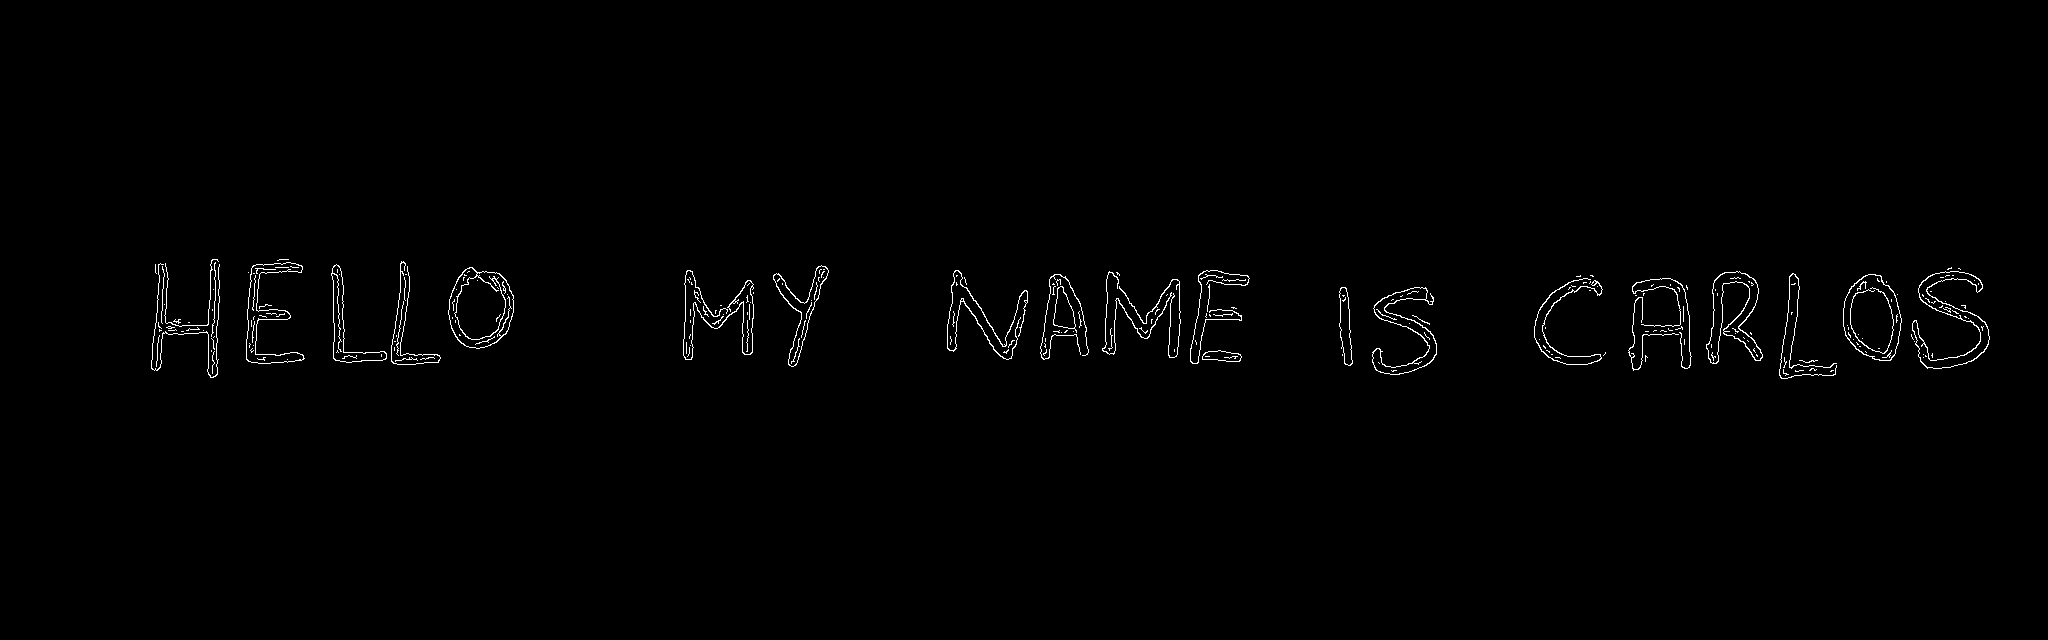

In [135]:
cv2_imshow(edged_image)